<a href="https://colab.research.google.com/github/TheGwAck/Projects/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sys, os
import numpy as np

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import optimizers
import shutil

Import data into Colab using a drive link. We then reformat the directory so that we can do our own validation split.

In [ ]:
# Download a file based on its file ID.
file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

Downloading...
From: https://drive.google.com/uc?id=18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn
To: /content/PlantVillage.zip
866MB [00:06, 140MB/s]


In [ ]:
!rsync -a -P --ignore-existing PlantVillage/train/ PlantVillage/val

Streaming output truncated to the last 5000 lines.
         20,092 100%   18.85kB/s    0:00:01 (xfr#41518, ir-chk=1926/43484)
Tomato___Tomato_Yellow_Leaf_Curl_Virus/eb5df69a-d470-4487-aa27-a5609e0c6ee2___UF.GRC_YLCV_Lab 02584.JPG
          9,980 100%    9.36kB/s    0:00:01 (xfr#41519, ir-chk=1925/43484)
Tomato___Tomato_Yellow_Leaf_Curl_Virus/eb613923-0d8d-4ebd-914b-fa52188c0630___UF.GRC_YLCV_Lab 03182.JPG
          8,646 100%    8.11kB/s    0:00:01 (xfr#41520, ir-chk=1924/43484)
Tomato___Tomato_Yellow_Leaf_Curl_Virus/eb70e5e4-bea1-4510-b942-4eb644adc5a7___YLCV_GCREC 2564.JPG
         16,822 100%   15.78kB/s    0:00:01 (xfr#41521, ir-chk=1923/43484)
Tomato___Tomato_Yellow_Leaf_Curl_Virus/eb773c59-262b-44ca-8ed2-5393a43818a2___UF.GRC_YLCV_Lab 01253.JPG
          8,200 100%    7.69kB/s    0:00:01 (xfr#41522, ir-chk=1922/43484)
Tomato___Tomato_Yellow_Leaf_Curl_Virus/eb78022e-bc77-473a-96a1-d1d9dd014e3b___UF.GRC_YLCV_Lab 01661.JPG
          6,557 100%    6.15kB/s    0:00:01 (xfr#41523, ir-c

In [ ]:
!rsync -a -P --ignore-existing PlantVillage/val/ PlantVillage

sending incremental file list
./
background/
background/0000047.jpg
         11,477 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=714/55060)
background/0000051.jpg
          6,154 100%    5.87MB/s    0:00:00 (xfr#2, to-chk=713/55060)
background/0000059.jpg
         13,181 100%   12.57MB/s    0:00:00 (xfr#3, to-chk=712/55060)
background/0000072.jpg
         10,589 100%   10.10MB/s    0:00:00 (xfr#4, to-chk=711/55060)
background/0000087.jpg
         12,760 100%   12.17MB/s    0:00:00 (xfr#5, to-chk=710/55060)
background/0000176.jpg
         16,113 100%   15.37MB/s    0:00:00 (xfr#6, to-chk=709/55060)
background/0000382.jpg
         20,165 100%   19.23MB/s    0:00:00 (xfr#7, to-chk=708/55060)
background/0000631.jpg
          5,928 100%    5.65MB/s    0:00:00 (xfr#8, to-chk=707/55060)
background/0000643.jpg
         10,863 100%   10.36MB/s    0:00:00 (xfr#9, to-chk=706/55060)
background/0000697.jpg
         10,797 100%   10.30MB/s    0:00:00 (xfr#10, to-chk=705/55060)
background/0000759.jpg
 

In [ ]:
rm -rf PlantVillage/val

In [ ]:
rm -rf PlantVillage/train

In [ ]:
rm -rf PlantVillage/background

Define some parameters for the dataset.

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

We load our images from the directory with an 80-20 train-test split.

In [ ]:
import pathlib
path = "PlantVillage"
data_dir = pathlib.Path(path)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode="categorical",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))

Preprocessing inputs for ResNet50


In [ ]:
def preprocess_resnet(image, label):
    resized_image = tf.image.resize(image, [256, 256])
    final_image = keras.applications.resnet50.preprocess_input(resized_image)
    return final_image, label

In [ ]:
train_set = train_ds.shuffle(1000)
train_set = train_ds.map(preprocess_resnet)
val_set = val_ds.map(preprocess_resnet)

In [ ]:
val_set.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))

Setting up Transfer Learning

In [ ]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
resnet = resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet_model = Model(resnet.input, output)

resnet_model.trainable = True

set_trainable = False
for layer in resnet_model.layers[1:143]:
  layer.trainable=False
for i, layer in enumerate(resnet_model.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_2 - True
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - F

Set up Model Architecture

In [ ]:
from tensorflow.keras import layers
model = models.Sequential()

model.add(res_model)
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Dense(38, activation='softmax'))

input_shape = (None, 256, 256, 3)
model.build(input_shape)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
history = model.fit(train_set, 
                    epochs=30,
                    validation_data=val_set)

model.save("plantvillage_resnet50.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 131072)            23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 131072)            524288    
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


We have achieved a validation accuracy of 0.9828

Plot loss and accuracy for the test and validation 

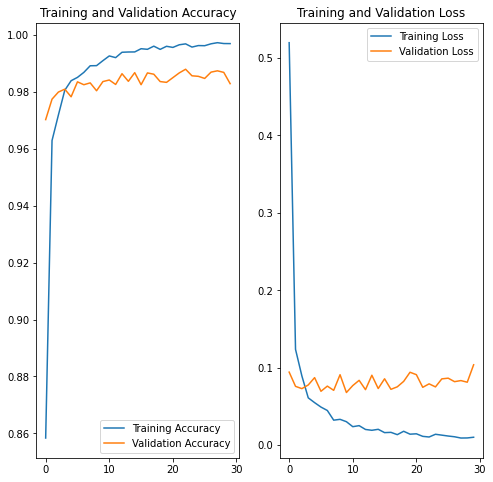

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Test model on random images from the dataset

In [ ]:
loaded_model = tf.keras.models.load_model('plant_village.resnet.h5')

In [ ]:
batch_holder = np.zeros((5, img_height, img_width, 3))
img_dir='drive/MyDrive/test'
for i,img in enumerate(os.listdir(img_dir)):
  img = tf.keras.preprocessing.image.load_img(os.path.join(img_dir,img), target_size=(img_height,img_width))
  batch_holder[i, :] = img
predict = model.predict(batch_holder)
Y_proba = np.argmax(predict, axis=-1)
for i in Y_proba:
  print(class_names[i])
  print(i)

Tomato___Septoria_leaf_spot
32
Tomato___healthy
37
Squash___Powdery_mildew
25
Grape___Black_rot
11
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
7
